In [ ]:
# Link to Data: https://drive.google.com/drive/folders/1FUnD_2VTPth5raQ0AqakMUpBeHkoKZCV?usp=sharing
# Link to Colab Notebook: https://colab.research.google.com/drive/1sNMrsdQNwMvvIRCReyg1nH-PwXG4e9KR?usp=sharing

In [ ]:
import os
import sys
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

from keras.models import Sequential 
from keras.layers import * 
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
# Constants
BATCH_SIZE = 32
NUM_CLASSES = 2
IMG_SIZE = 224
NUM_EPOCHS = 30
TRAIN_SIZE = 0.96
TEST_SIZE = 0.04

SEED = 1234
tf.random.set_seed(SEED)

FILE_DIR = "/content/gdrive/MyDrive/cxc/aipaca"

# Ignore Invalid Files

In [ ]:
classes = os.listdir(FILE_DIR)
filepaths = []
labels = []
acc_ext_list = ['jpg', 'jpeg', 'png']

for c in classes:
    c_path = os.path.join(FILE_DIR, c)
    print('processing class directory ', c)
    if os.path.isdir(c_path):
        file_list = os.listdir(c_path)
        for f in file_list:               
            f_path = os.path.join(c_path, f)
            index = f.rfind('.')
            ext = f[index+1:].lower()
            if ext not in acc_ext_list:
                print('file ', f_path, ' has an invalid extension ', ext)

            if os.path.isfile(f_path):
                try:
                    img=cv2.imread(f_path)
                    filepaths.append(f_path)
                    labels.append(c)
                except:
                    print('file ', f_path, ' is not a valid image file')
            else:
                print('*** fatal error, you have a sub directory ', f, ' in class directory ', c)
    else:
        print ('*** WARNING*** you have files in ', classes, ' it should only contain sub directories')

print('filepaths: ', len(filepaths), '    labels: ', len(labels))

processing class directory  not alpaca
processing class directory  alpaca
filepaths:  367     labels:  367


# Create Dataframe of Images

In [ ]:
Fseries = pd.Series(filepaths, name='file_paths')
Lseries = pd.Series(labels, name='labels')

df = pd.concat([Fseries, Lseries], axis=1)
df = pd.DataFrame(np.array(df).reshape(len(filepaths),2), columns=['file_paths', 'labels'])

print(df['labels'].value_counts())

not alpaca    186
alpaca        181
Name: labels, dtype: int64


# Visualize Images

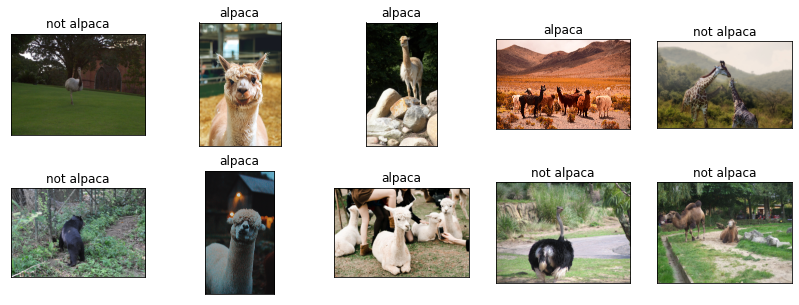

In [ ]:
plt.figure(figsize=(14,5))
for i in range(10):
  random = np.random.randint(1, len(df))
  plt.subplot(2,5,i+1)
  img = df.loc[random, 'file_paths']
  plt.imshow(plt.imread(img))
  plt.title(df.loc[random, 'labels'])
  plt.xticks([])
  plt.yticks([])

plt.show()


# Split Dataframe for Train and Validation

In [ ]:
train_df, test_df = train_test_split(df, 
                                     train_size=TRAIN_SIZE, 
                                     random_state=SEED)
train_df, valid_df = train_test_split(train_df, 
                                      train_size=TRAIN_SIZE, 
                                      random_state=SEED)

print(train_df.labels.value_counts())
print(valid_df.labels.value_counts())
print(test_df.labels.value_counts())

not alpaca    170
alpaca        167
Name: labels, dtype: int64
alpaca        8
not alpaca    7
Name: labels, dtype: int64
not alpaca    9
alpaca        6
Name: labels, dtype: int64


In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
)

train_gen = train_datagen.flow_from_dataframe(
    train_df, 
    x_col='file_paths', y_col='labels', 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='binary')
valid_gen = train_datagen.flow_from_dataframe(
    valid_df, 
    x_col='file_paths', y_col='labels', 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='binary')
test_gen = train_datagen.flow_from_dataframe(
    test_df, 
    x_col='file_paths', y_col='labels', 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='binary')


Found 337 validated image filenames belonging to 2 classes.
Found 15 validated image filenames belonging to 2 classes.
Found 15 validated image filenames belonging to 2 classes.


# EfficientNetB3-based Model

In [ ]:
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

model = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Defining Callback functions
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        '/content/gdrive/MyDrive/cxc/classify_model_weights.h5', 
        save_best_only=True, 
        verbose=0
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=5,
        monitor='val_loss',
        mode='min',
        verbose=1,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=2,
        verbose=1
    )
]

In [ ]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=NUM_EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
11/11 [==============================] - 34s 3s/step - loss: 0.2607 - accuracy: 0.8932 - val_loss: 0.4818 - val_accuracy: 0.7333 - lr: 9.0000e-05
Epoch 2/30
11/11 [==============================] - 33s 3s/step - loss: 0.1125 - accuracy: 0.9525 - val_loss: 0.4681 - val_accuracy: 0.7333 - lr: 9.0000e-05
Epoch 3/30
11/11 [==============================] - 33s 3s/step - loss: 0.1095 - accuracy: 0.9614 - val_loss: 0.3626 - val_accuracy: 0.8000 - lr: 9.0000e-05
Epoch 4/30
11/11 [==============================] - 30s 3s/step - loss: 0.1242 - accuracy: 0.9525 - val_loss: 0.5594 - val_accuracy: 0.8000 - lr: 9.0000e-05
Epoch 5/30
11/11 [==============================] - ETA: 0s - loss: 0.0588 - accuracy: 0.9852
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
11/11 [==============================] - 30s 3s/step - loss: 0.0588 - accuracy: 0.9852 - val_loss: 0.5107 - val_accuracy: 0.8000 - lr: 9.0000e-05
Epoch 6/30
11/11 [==============================] - 29s 

In [ ]:
# Save Model to directory (Saved to Google Drive)
model.save('/content/gdrive/MyDrive/cxc/saved_model/aipaca_model')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/cxc/saved_model/aipaca_model/assets


# Load Saved Model

In [ ]:
loaded_model = tf.keras.models.load_model('/saved_model/aipaca_model')

In [ ]:
loaded_model.evaluate(test_gen)

1/1 [==============================] - 4s 4s/step - loss: 0.4342 - accuracy: 0.8667


[0.4341588318347931, 0.8666666746139526]

# Predict Image using Saved Model

In [ ]:
img_path = filepaths[0] # Change image filepath here
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))

x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.efficientnet.preprocess_input(x)

preds = loaded_model.predict(x)

np.rint(preds[0][0]) # 1: not alpaca, 0: alpaca

'not alpaca'